We will explore a task of forecasting time series with the help of neural networks. We will predict temperature using weather data from Max plank Institute.

Data Link :# data source: Max Plank Institute, https://www.bgc-jena.mpg.de/wetter/

We will start with downloading a dataset of meteorological observations from Jena in Germany

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-07-17 08:13:24--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.78.206, 52.217.226.200, 54.231.160.16, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.78.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.94MB/s    in 2.2s    

2023-07-17 08:13:27 (5.94 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

It contains 14 different meteorological variables, dating back to 2009. The data was recorded every 10 minutes.

There are 420,451 lines of data in total. Each line here is a timestep.

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
  data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import pandas as pd
df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [35]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1] #
  raw_data[i, :] = values[:] #

In [43]:
raw_data.shape

(420451, 14)

Visualising the temperature dataset. We can clearly see the annual cycle in temperature data over 8 years.

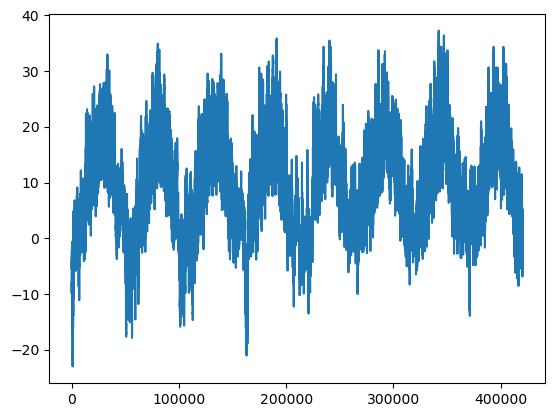

In [44]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

Zooming in the first 10 days of data. Since our measurements were taken every 10 minutes, we will have 1440 datapoints.

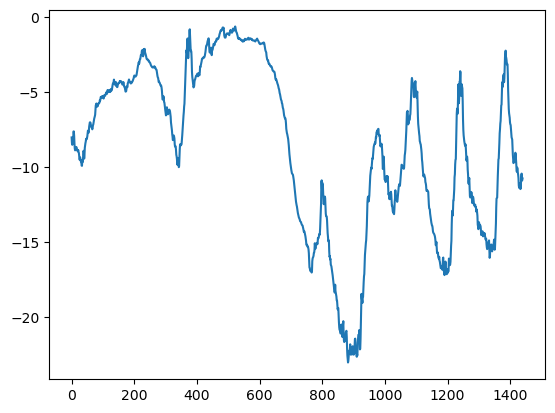

In [47]:
plt.plot(range(1440), temperature[:1440])

We can clearly see, that it would be harder to predict temperature on a daily basis rather than monthly as there is more variability in the daily data. We will try to predict temperature one day ahead. We will reserve 50% of data for training, 25% for validation and the rest for test. Since we are dealing with a time series, we need to make sure that validation follows training set in time.

In [48]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


First of all, our data was measured in different units, so we will rescale the data using mean and standard deviation of the training data.

In [49]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Using a function embedded in Keras - timeseries_dataset_from_array.

We will create three datasets - training, validation and testing. The advantage of using this function is that we can effeciently sample batches of data and save computational time. 
We will utlise the following parameters: 

*sampling rate*=6 - since we would like to have only one sample per hour

*sequence length*=120 - as we would like to have 5 past days of observations: 24*5


*delay*=sampling_rate * (sequence_length + 24 - 1) - The target
for a sequence will be the temperature 24 hours after the end of the sequence.

In [50]:
from tensorflow import keras
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
  raw_data[:-delay],
  targets=temperature[delay:],
  sampling_rate=sampling_rate,
  sequence_length=sequence_length,
  shuffle=True,
  batch_size=batch_size,
  start_index=0,
  end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
  raw_data[:-delay],
  targets=temperature[delay:],
  sampling_rate=sampling_rate,
  sequence_length=sequence_length,
  shuffle=True,
  batch_size=batch_size,
  start_index=num_train_samples,
  end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
  raw_data[:-delay],
  targets=temperature[delay:],
  sampling_rate=sampling_rate,
  sequence_length=sequence_length,
  shuffle=True,
  batch_size=batch_size,
  start_index=num_train_samples + num_val_samples)

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures.

In [10]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


**Simple baseline**

First we will try a very simple baseline.

We can assume that temperature is continious. In other words, there are not many changes from one day to the next. The temperatures tomorrow are likely be close to temperatures today.Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature
right now. We will implement such baseline and use MAE for error metric.

In [54]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1] #  the loop iterates over the dataset, selects the last time step of each sample, scales and shifts the predictions using the provided std and mean values, and stores the predictions in the preds variable.
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

We can see that using this simple baseline, we would be on average 2.6 degrees C off in our predictions.

In [55]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**LSTM Model**

In [57]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("jena_lstm.keras",
save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 54s 63ms/step - loss: 42.3207 - mae: 4.7357 - val_loss: 16.1452 - val_mae: 2.8820
Epoch 2/10
819/819 [==============================] - 56s 68ms/step - loss: 11.1752 - mae: 2.5947 - val_loss: 9.6213 - val_mae: 2.4170
Epoch 3/10
819/819 [==============================] - 50s 61ms/step - loss: 9.9860 - mae: 2.4657 - val_loss: 9.5620 - val_mae: 2.4216
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 9.5682 - mae: 2.4091 - val_loss: 9.8476 - val_mae: 2.4359
Epoch 5/10
819/819 [==============================] - 57s 69ms/step - loss: 9.1847 - mae: 2.3618 - val_loss: 9.5218 - val_mae: 2.4070
Epoch 6/10
819/819 [==============================] - 57s 69ms/step - loss: 8.8155 - mae: 2.3169 - val_loss: 9.7612 - val_mae: 2.4205
Epoch 7/10
819/819 [==============================] - 56s 68ms/step - loss: 8.5258 - mae: 2.2798 - val_loss: 9.9506 - val_mae: 2.4400
Epoch 8/10
819/819 [==============================] - 56s 6

We achieve a validation MAE as low as 2.4 degrees and a test MAE of 2.5 degrees

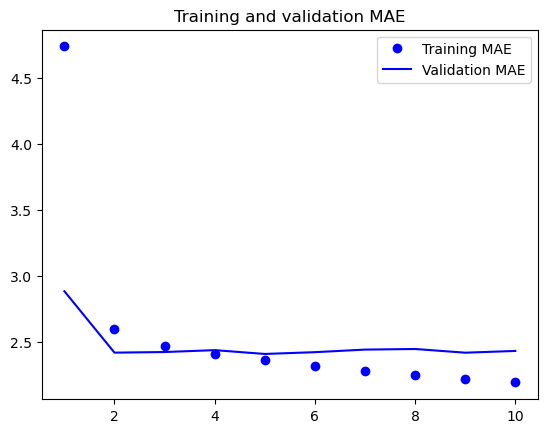

In [58]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

405/405 [==============================] - 16s 39ms/step


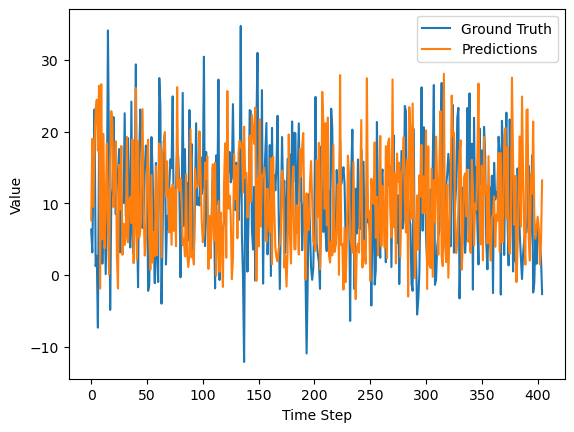

In [61]:
import numpy as np

# Predict on the test data
predictions = model.predict(test_dataset)

# Extract the target values from the test dataset
test_targets = []
for i, j in test_dataset:
  test_targets.append(j[0].numpy())

# Prepare the x-axis values
x_values = np.arange(len(test_targets))

# Create a plot to visualize the predicted values and ground truth values
plt.plot(x_values, test_targets, label='Ground Truth')
plt.plot(x_values, predictions.flatten()[:len(test_targets)], label='Predictions')

# Add labels and a legend to the plot
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()
